In [2]:
import cv2
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt

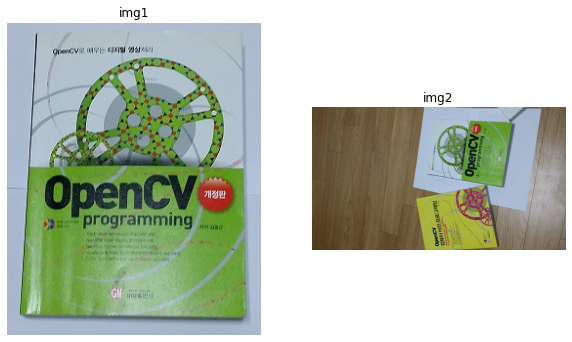

In [6]:
src1_bgr=cv2.imread('./data/book1.jpg')
src2_bgr=cv2.imread('./data/book2.jpg')
img1=cv2.cvtColor(src1_bgr,cv2.COLOR_BGR2GRAY)
img2=cv2.cvtColor(scr2_bgr,cv2.COLOR_BGR2GRAY)

# plt로 imshow하려면 rgb객체가 필요함 
src1_rgb=cv2.cvtColor(src1_bgr,cv2.COLOR_BGR2RGB)
src2_rgb=cv2.cvtColor(src2_bgr,cv2.COLOR_BGR2RGB)

plt.figure(figsize=(10,30))
image=plt.subplot(1,2,1)
image.set_title('img1')
plt.axis('off')
plt.imshow(src1_rgb)
image=plt.subplot(1,2,2)
image.set_title('img2')
plt.axis('off')
plt.imshow(src2_rgb)

len(matches)= 340
matches[0]=(queryIdx:310, trainIdx:215, distance:10.0)
matches[1]=(queryIdx:413, trainIdx:328, distance:12.0)
matches[2]=(queryIdx:355, trainIdx:127, distance:15.0)
matches[3]=(queryIdx:430, trainIdx:361, distance:15.0)
matches[4]=(queryIdx:236, trainIdx:148, distance:16.0)
matches[5]=(queryIdx:615, trainIdx:459, distance:17.0)
matches[6]=(queryIdx:685, trainIdx:650, distance:17.0)
matches[7]=(queryIdx:224, trainIdx:149, distance:18.0)
matches[8]=(queryIdx:428, trainIdx:391, distance:18.0)
matches[9]=(queryIdx:495, trainIdx:385, distance:18.0)


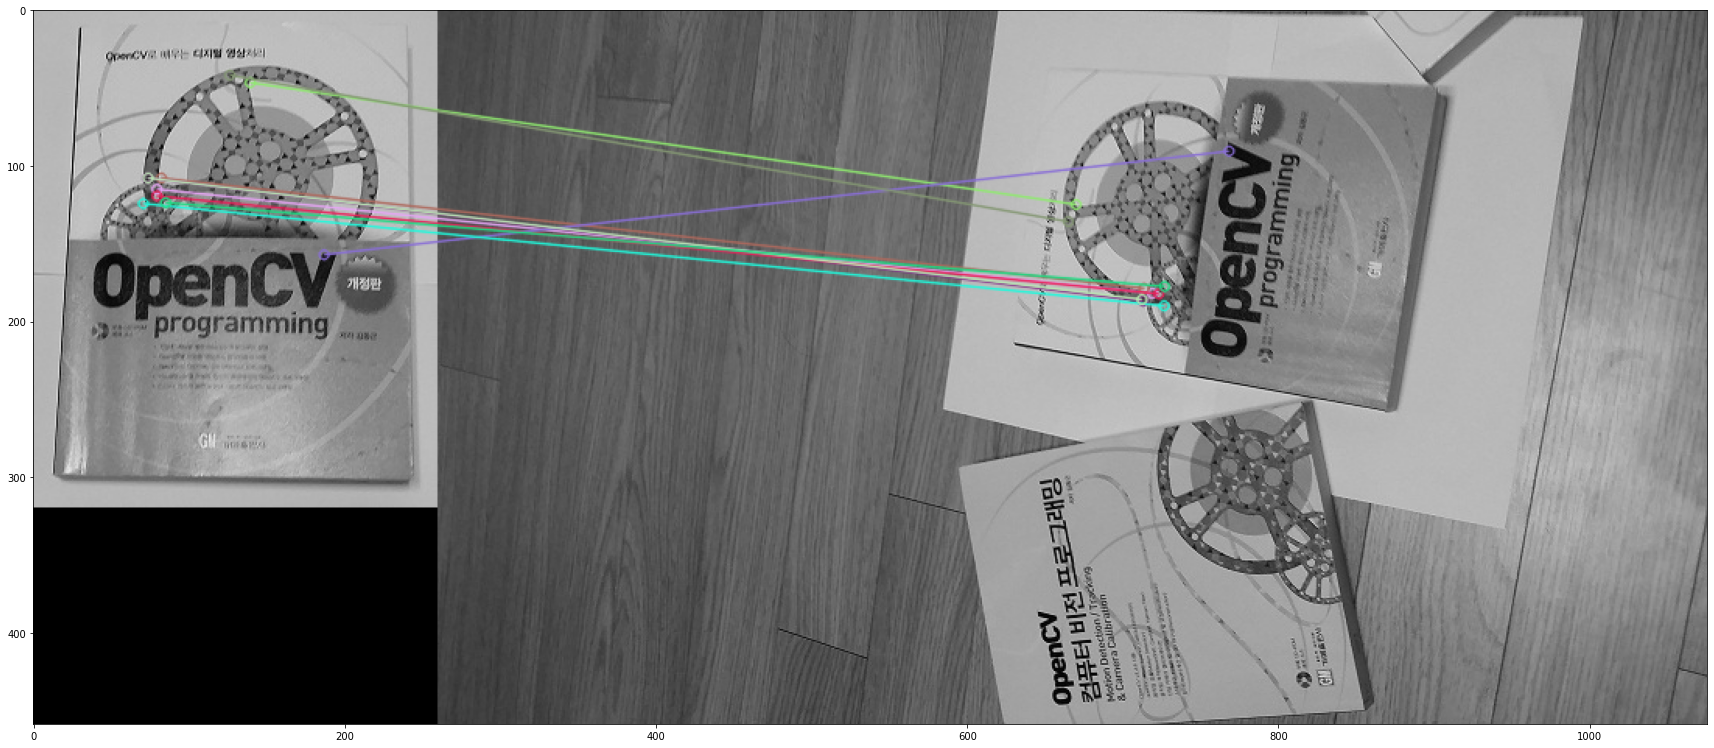

In [7]:
# descriptor
orb=cv2.ORB_create(nfeatures=1000) # orb-bf, orb-flann pair (디스크립터-매처), 키 포인트를 1000개 정도로 찾아라
brisk=cv2.BRISK_create() # brisk-bf, brisk-flann pair 
detector=[orb,brisk]

didx=0 # -> orb로 디스크립터 생성
# detect로 키포인트 찾고 compute로 디스크립터 계산 -> kp1: 키포인트 정보, des1: 디스크립터 정보
kp1,des1=detector[didx].detectAndCompute(img1,None) 
kp2,des2=detector[didx].detectAndCompute(img2,None) 

# matcher
# distance: 해밍 거리 (서로 다른 비트의 개수:거리[차이]), crossCheck를 하면 더 정확하게 찾음
bf=cv2.BFMatcher_create(cv2.NORM_HAMMING, crossCheck=True) 
flann=cv2.FlannBasedMatcher_create()
matcher=[bf,flann]

midx=0 # -> bf로 매칭 (orb-bf사용)      
try: # bf면 정상적으로 실행됨, plann이면 에러남
    matches=matcher[midx].match(des1,des2)
except: # midx=1 -> plann이어서 에러나면 실행함
    matches=matcher[midx].match(np.float32(des1).np.float32(des2))

# result display  (매칭의 결과를 보여줌) 
matches=sorted(matches,key=lambda x:x.distance) # x:x.distance로 오름차순
print('len(matches)=',len(matches))
for i,m in enumerate(matches[:10]): # 상위 10개만 보기
    # queryIdx: img1에 대한 키포인트 인덱스, trainIdx: img2에 대한 키포인트 인덱스, distance: 두 개의 키 포인트의 distance
    print('matches[{}]=(queryIdx:{}, trainIdx:{}, distance:{})'.format(i,m.queryIdx,m.trainIdx,m.distance))

img3=cv2.drawMatches(img1,kp1,img2,kp2,matches[:10],None,flags=2) # 10개만 출력 
plt.figure(figsize=(30,60))
plt.imshow(img3)
plt.show()

len(good_matches)= 13


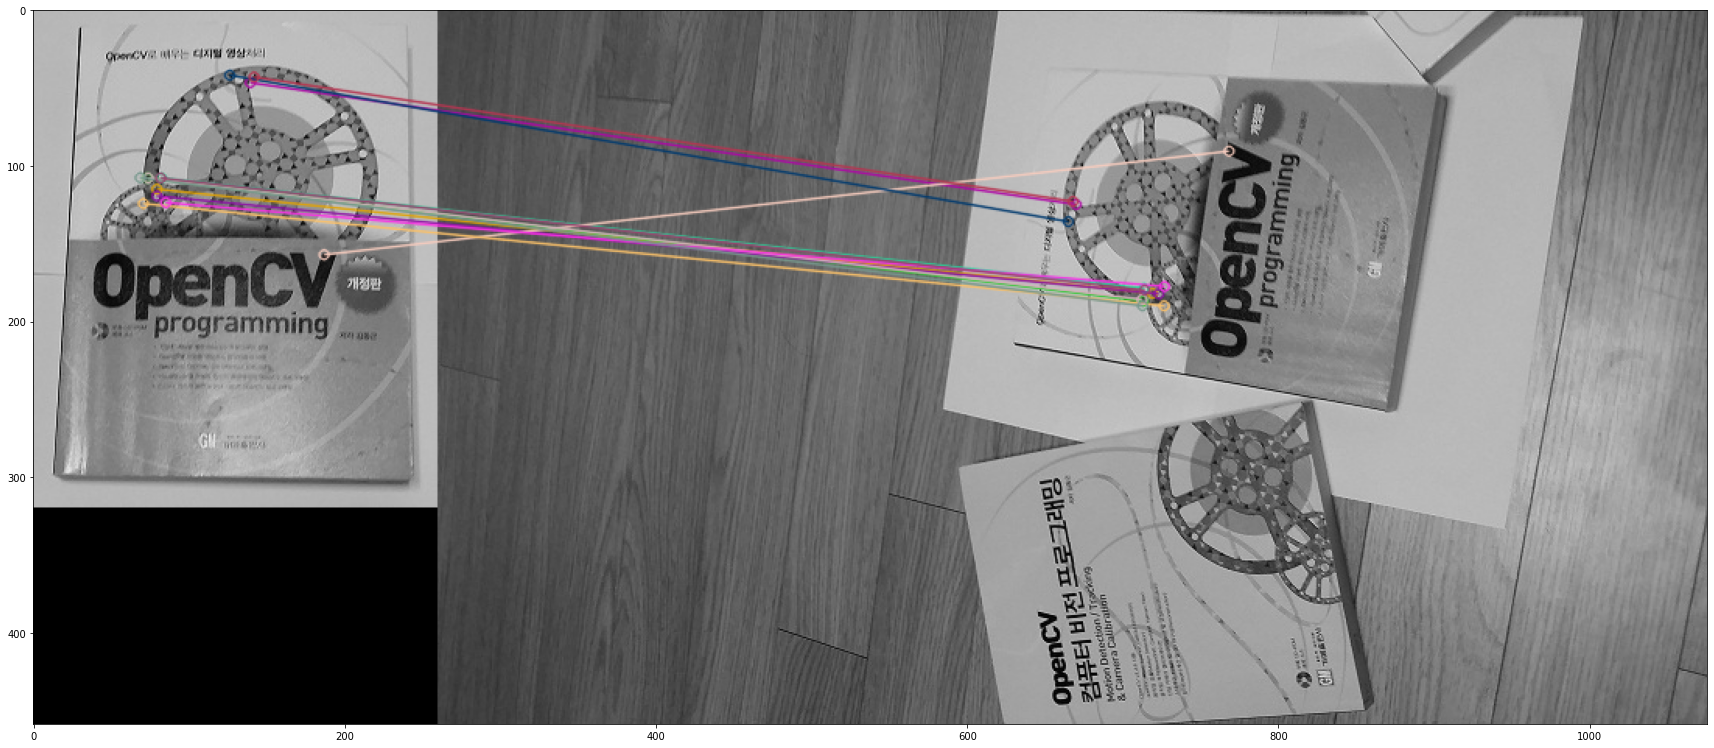

In [8]:
# draw only good matching
minDist=matches[0].distance
# matches의 distance를 확인해서 minDist의 2배보다 작은 것만 good_matches로 만들기
good_matches=list(filter(lambda m:m.distance <= 2*minDist,matches))
print('len(good_matches)=',len(good_matches))
if len(good_matches) <5:
    print('sorry, too small good matches')
    exit()

img4=cv2.drawMatches(img1,kp1,img2,kp2,good_matches,None,flags=2)
plt.figure(figsize=(30,60))
plt.imshow(img4)
plt.show()

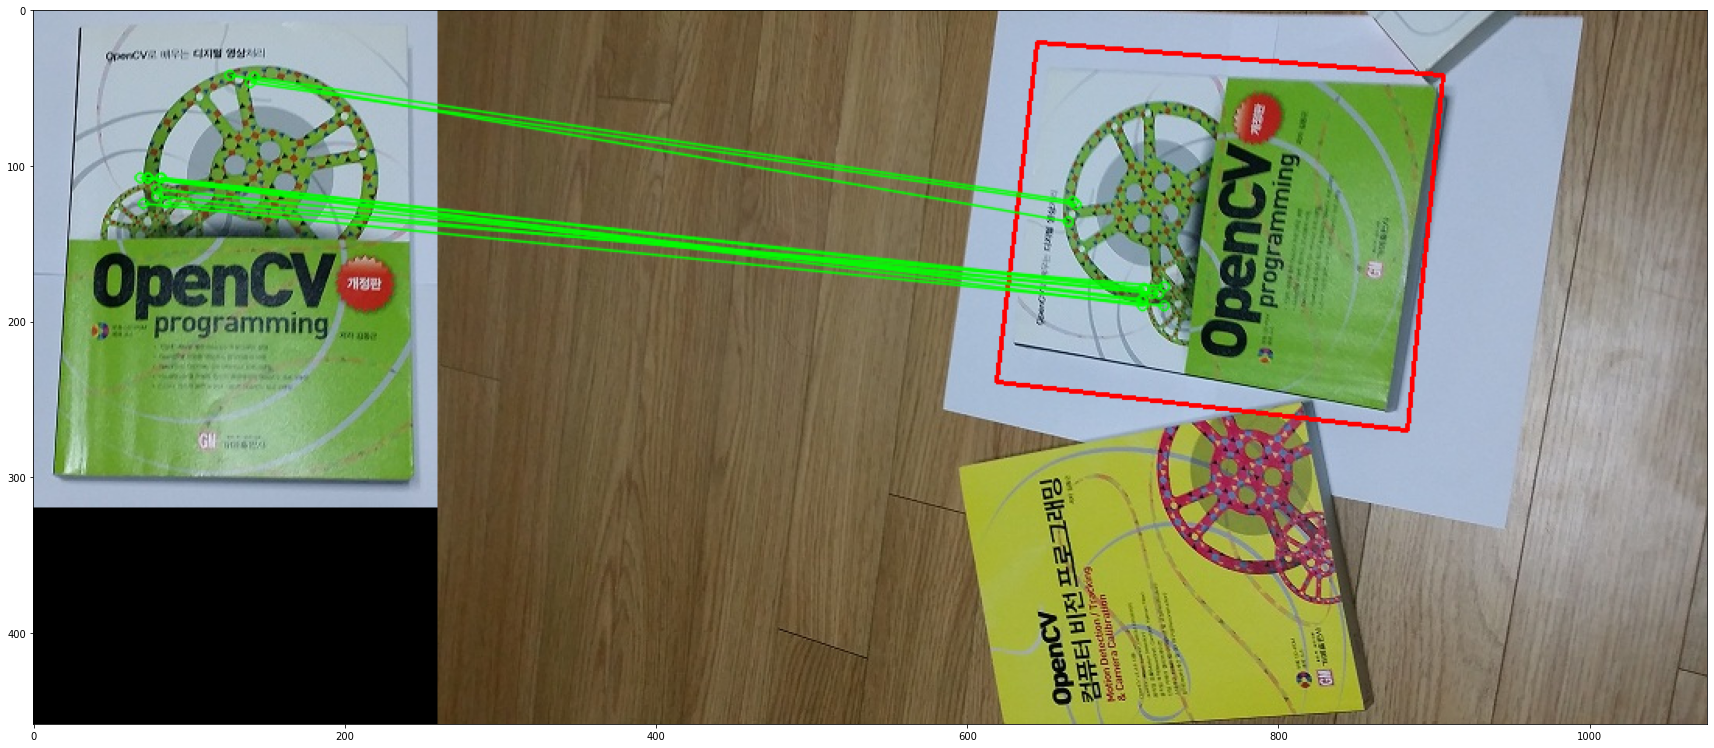

In [11]:
src1_pts=np.float32([kp1[m.queryIdx].pt for m in good_matches])
src2_pts=np.float32([kp2[m.trainIdx].pt for m in good_matches])

# h는 호모그래피 행렬, mask는 inlier면 1, 아니면 0으로 저장 
H,mask=cv2.findHomography(src1_pts,src2_pts,cv2.RANSAC,3.0)
mask_matches=mask.flatten().tolist()

# 모서리 네 점에 호모그래피 행렬 적용 -> 
h,w=img1.shape
pts=np.float32([[0,0],[0,h-1],[w-1,h-1],[w-1,0]]).reshape(-1,1,2) # 네 점
pts2=cv2.perspectiveTransform(pts,H) # 적용 (perspectiveTransform으로 곱함, 변환된 점 반환)
src2_rgb=cv2.polylines(src2_rgb,[np.int32(pts2)],True,(255,0,0),2) # 그림 그리기

draw_params=dict(matchColor=(0,255,0),singlePointColor=None,matchesMask=mask_matches,flags=2)
img5=cv2.drawMatches(src1_rgb,kp1,src2_rgb,kp2,good_matches,None,**draw_params)
plt.figure(figsize=(30,60))
plt.imshow(img5)
plt.show()